In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.frequent_patterns import apriori, association_rules # generate association rules

sns.set(style="whitegrid")

DATA_PROCESSED = Path("../data/processed")
FIG_DIR = Path("../reports/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# Load BasketID × Product × Quantity table
basket_qty = pd.read_parquet(DATA_PROCESSED / "basket_qty.parquet")
basket_qty.head()

,BasketID,Product,Quantity
0,493414,hand open shape gold,2
1,493414,new england ceramic cake server,2
2,493414,retro spot large milk jug,12
3,493414,retro spot mug,36
4,493414,retro spot sugar jam bowl,24


In [5]:
# Pivot into a basket x product matrix
# Each row = a basket
# Each column = a product
# Cell = total quantity of that product in that basket

basket_matrix = basket_qty.pivot_table(
    index="BasketID",
    columns="Product",
    values="Quantity",
    aggfunc="sum",
    fill_value=0
)

basket_matrix.head()

Product,10 colour spaceboy pen,12 ass zinc christmas decorations,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 ivory rose peg place settings,12 message cards with envelopes,12 mini toadstool pegs,12 pencil small tube woodland,12 pencils small tube posy,...,zinc heart lattice charger large,zinc heart lattice charger small,zinc heart lattice double planter,zinc heart lattice planter bowl,zinc heart lattice t-light holder,zinc heart lattice tray oval,zinc metal heart decoration,zinc police box lantern,zinc top 2 door wooden shelf,zinc willie winkie candle stick
BasketID,,,,,,,,,,,,,,,,,,,,,
493414,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
493427,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
493428,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
493432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
493433,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Convert quantities to binary indicator:
# 1 = product appears at least once in the basket
# 0 = product not present

basket_matrix_binary = (basket_matrix > 0).astype(int)

print("Matrix shape:", basket_matrix_binary.shape)  # (num_baskets, num_products)


Matrix shape: (16178, 4240)


In [12]:
# Run Apriori to find frequent itemsets
# min_support=0.002 means: itemsets that appear in at least 0.2% of baskets

frequent_itemsets = apriori(
    basket_matrix_binary,
    min_support=0.002,
    use_colnames=True,   # use product names instead of column indices
    low_memory=True
)

# Add a 'length' column = number of items in each itemset
frequent_itemsets["length"] = frequent_itemsets["itemsets"].apply(len)

frequent_itemsets.head()

/opt/anaconda3/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets,length
0,0.013290,(10 colour spaceboy pen),1
1,0.006490,(12 coloured party balloons),1
2,0.006799,(12 daisy pegs in wood box),1
3,0.003894,(12 egg house painted wood),1
4,0.007541,(12 ivory rose peg place settings),1


In [14]:
# Check how many itemsets of each size we have (1, 2, 3, ...)
frequent_itemsets["length"].value_counts().sort_index()

length
1      2026
2     11850
3      6292
4      2740
5      1287
6       646
7       277
8        93
9        20
10        2
Name: count, dtype: int64

In [16]:
# Generate association rules from the frequent itemsets
# metric="lift" and min_threshold=1.0 means: only keep rules with lift >= 1
rules = association_rules(
    frequent_itemsets,
    metric="lift",
    min_threshold=1.0
)

rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(lunch bag spaceboy design),(10 colour spaceboy pen),0.051119,0.013290,0.002411,0.047158,3.548505,1.0,0.001731,1.035545,0.756882,0.038883,0.034325,0.114277
1,(10 colour spaceboy pen),(lunch bag spaceboy design),0.013290,0.051119,0.002411,0.181395,3.548505,1.0,0.001731,1.159145,0.727864,0.038883,0.137295,0.114277
2,(magic drawing slate spaceboy),(10 colour spaceboy pen),0.013846,0.013290,0.002163,0.156250,11.757267,1.0,0.001979,1.169434,0.927792,0.086634,0.144886,0.159520
3,(10 colour spaceboy pen),(magic drawing slate spaceboy),0.013290,0.013846,0.002163,0.162791,11.757267,1.0,0.001979,1.177906,0.927269,0.086634,0.151036,0.159520
4,(10 colour spaceboy pen),(pink cream felt craft trinket box),0.013290,0.039560,0.002163,0.162791,4.115044,1.0,0.001638,1.147192,0.767185,0.042683,0.128307,0.108739


In [18]:
# Number of items in the antecedent (left-hand side)
rules["antecedent_len"] = rules["antecedents"].apply(len)

# Number of items in the consequent (right-hand side)
rules["consequent_len"] = rules["consequents"].apply(len)

# Convert frozensets to readable comma-separated strings
rules["antecedents_str"] = rules["antecedents"].apply(
    lambda s: ", ".join(sorted(list(s)))
)
rules["consequents_str"] = rules["consequents"].apply(
    lambda s: ", ".join(sorted(list(s)))
)

rules[[
    "antecedents_str",
    "consequents_str",
    "support",
    "confidence",
    "lift"
]].head()

,antecedents_str,consequents_str,support,confidence,lift
0,lunch bag spaceboy design,10 colour spaceboy pen,0.002411,0.047158,3.548505
1,10 colour spaceboy pen,lunch bag spaceboy design,0.002411,0.181395,3.548505
2,magic drawing slate spaceboy,10 colour spaceboy pen,0.002163,0.156250,11.757267
3,10 colour spaceboy pen,magic drawing slate spaceboy,0.002163,0.162791,11.757267
4,10 colour spaceboy pen,pink cream felt craft trinket box,0.002163,0.162791,4.115044


In [20]:
# We’ll pick rules that are:

'''
1. confidence ≥ 0.3
2. lift ≥ 1.1
3. consequent has exactly 1 item (simpler for recommendations)
'''


MIN_CONFIDENCE = 0.3
MIN_LIFT = 1.1

rules_filtered = rules[
    (rules["antecedent_len"] >= 1) &
    (rules["consequent_len"] == 1) &
    (rules["confidence"] >= MIN_CONFIDENCE) &
    (rules["lift"] >= MIN_LIFT)
].copy()

print("Total rules generated:", len(rules))
print("Rules after filtering:", len(rules_filtered))

rules_filtered[[
    "antecedents_str",
    "consequents_str",
    "support",
    "confidence",
    "lift"
]].head(10)

Total rules generated: 249078
Rules after filtering: 39898


,antecedents_str,consequents_str,support,confidence,lift
17,12 coloured party balloons,set of 9 heart shaped balloons,0.002040,0.314286,23.323460
18,12 ivory rose peg place settings,12 pink rose peg place settings,0.003091,0.409836,76.210665
19,12 pink rose peg place settings,12 ivory rose peg place settings,0.003091,0.574713,76.210665
20,12 ivory rose peg place settings,12 red rose peg place settings,0.002843,0.377049,66.303279
21,12 red rose peg place settings,12 ivory rose peg place settings,0.002843,0.500000,66.303279
36,12 pencil small tube woodland,12 pencils small tube skull,0.007417,0.555556,24.691697
37,12 pencils small tube skull,12 pencil small tube woodland,0.007417,0.329670,24.691697
72,12 pencils small tube red retrospot,12 pencils small tube skull,0.006923,0.670659,29.807462
73,12 pencils small tube skull,12 pencils small tube red retrospot,0.006923,0.307692,29.807462
86,12 pencils small tube red spotty,12 pencils small tube skull,0.007479,0.517094,22.982272


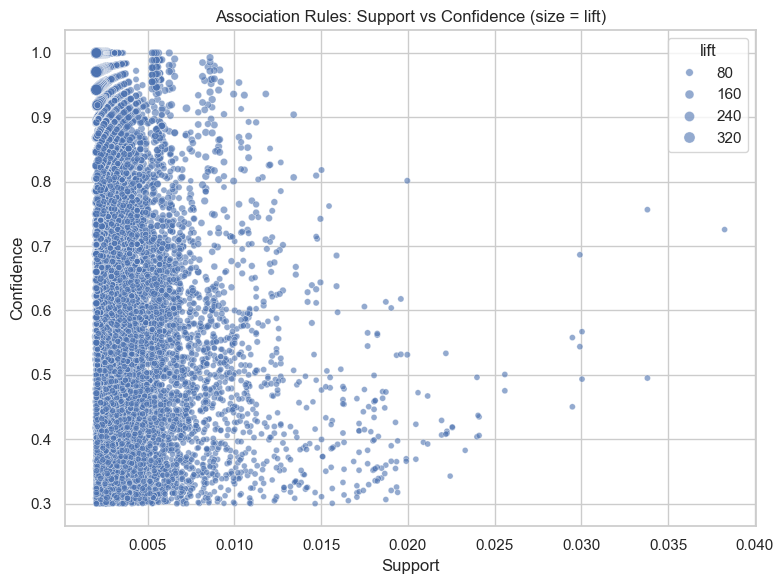

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rules_filtered,
    x="support",
    y="confidence",
    size="lift",
    alpha=0.6
)
plt.title("Association Rules: Support vs Confidence (size = lift)")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.tight_layout()

plt.savefig(FIG_DIR / "rules_support_vs_confidence.png")
plt.show()

/var/folders/mk/qm568t1n2t11r_13jw7_kn400000gn/T/ipykernel_19900/1101669080.py:12: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


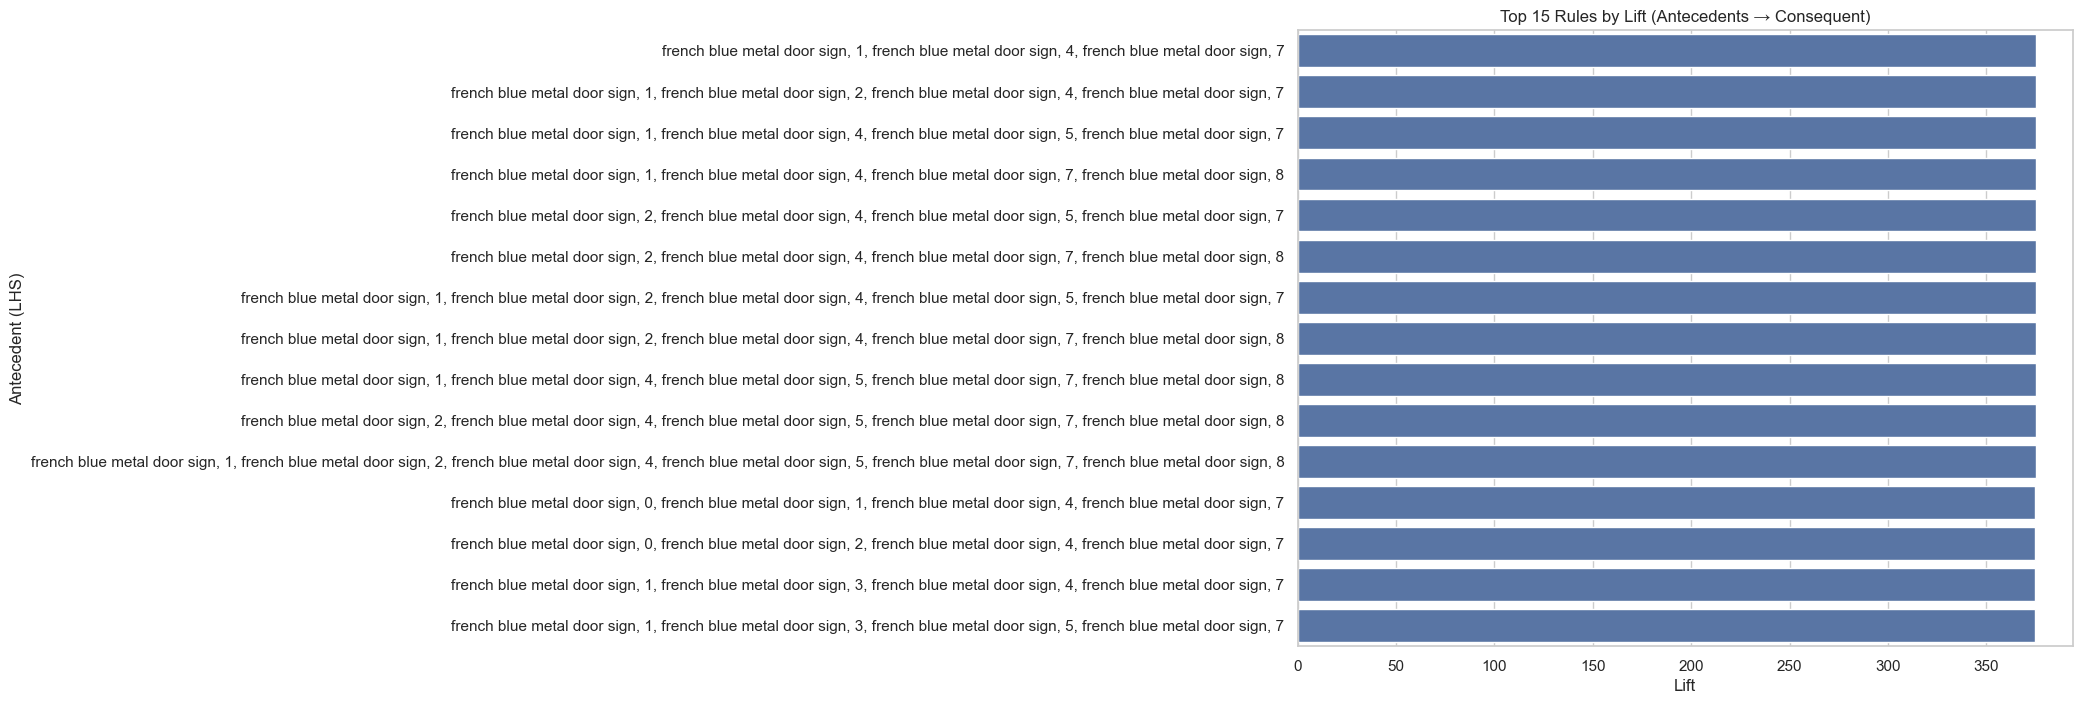

In [28]:
top_rules_lift = rules_filtered.nlargest(15, "lift")

plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_rules_lift,
    x="lift",
    y="antecedents_str"
)
plt.title("Top 15 Rules by Lift (Antecedents → Consequent)")
plt.xlabel("Lift")
plt.ylabel("Antecedent (LHS)")
plt.tight_layout()

plt.savefig(FIG_DIR / "top15_rules_by_lift.png")
plt.show()

In [30]:
rules_to_save = rules_filtered[[
    "support",
    "confidence",
    "lift",
    "antecedent_len",
    "consequent_len",
    "antecedents_str",
    "consequents_str"
]].copy()

rules_to_save.to_parquet(DATA_PROCESSED / "association_rules.parquet", index=False)
rules_to_save.to_csv(DATA_PROCESSED / "association_rules.csv", index=False)